In [7]:
import torch
print(torch.cuda.is_available())  # Should return True
print(torch.cuda.device_count())  # Should return the number of GPUs
print(torch.cuda.get_device_name(0))  # Should show the GPU model

True
1
NVIDIA RTX 5000 Ada Generation


In [8]:
import transformers
import torch
import os
import json
from huggingface_hub import login
from transformers import AutoTokenizer, AutoModelForCausalLM
import logging
import time
from datetime import timedelta, datetime
import pandas as pd
from dotenv import load_dotenv
import shutil 

import evaluate
from sentence_transformers import SentenceTransformer, util
import numpy as np

# Load environment variables
load_dotenv(dotenv_path="../../.env") # path is relative to this script, adjust as needed

True

In [9]:
# setting huggingface token
login(token=os.getenv("HUGGINGFACE_TOKEN"))
print("Hugging Face token set successfully.")
os.environ["HF_HOME"] = "D:/huggingface_cache" 
os.environ["TRANSFORMERS_CACHE"] = "D:/huggingface_cache"
os.environ["HUGGINGFACE_HUB_CACHE"] = "D:/huggingface_cache"
logging.info(f"Setting up Hugging Face environment variables...")

logging.info(f"HF_HOME: {os.getenv('HF_HOME')}")
logging.info(f"TRANSFORMERS_CACHE: {os.getenv('TRANSFORMERS_CACHE')}")
logging.info(f"HUGGINGFACE_HUB_CACHE: {os.getenv('HUGGINGFACE_HUB_CACHE')}")

transformers.utils.hub.TRANSFORMERS_CACHE = "D:/huggingface_cache"


model_name = "meta-llama/Meta-Llama-3-8B"

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True, trust_remote_code=True)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token  # Set pad token to eos token if not set

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    device_map="cuda",
    low_cpu_mem_usage=True,
    trust_remote_code=True
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Hugging Face token set successfully.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
      )
    )
    (n

In [10]:
model_name = "meta-llama/Meta-Llama-3-8B"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16, device_map="cuda")


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [11]:
# test chunk
chunk = '''
Chapter 1: Introduction
Chapter 2: Photosynthesis and Plant Growth

Photosynthesis is the process by which green plants convert sunlight into energy. This energy is essential for plant growth and food production. The process takes place in the chloroplasts of plant cells, where sunlight, carbon dioxide, and water are converted into glucose and oxygen.

Section 5.1: Economic Impacts of Climate Change

Recent studies have shown that rising global temperatures and extreme weather events can significantly affect agricultural yields, infrastructure stability, and overall economic productivity in both developed and developing nations.

Table of Contents

Preface ............................................. v  
Chapter 1: Introduction ............................. 1  
Chapter 2: Background ............................... 5  
Chapter 3: Methodology .............................. 12  
References ......................................... 45

References

1. Smith, J. (2021). Introduction to Biology. Academic Press.  
2. Jones, M. & Lee, K. (2020). Climate Science: A Global Perspective. Springer.  
3. WHO Report on Air Quality, 2019.

Preface

This book provides an overview of key topics in environmental science. The reader is encouraged to explore the chapters in sequence, but each chapter can also be read independently based on interest.

'''

In [12]:
def build_prompt(chunk, questions_num):
    return f"""
You are a question generation model. Only generate questions if the text segment below contains useful, topic-relevant content. Ignore and do not generate questions for sections like prefaces, indexes, tables of contents, references, or bibliographies.

If the chunk is not useful, return the string: "This chunk is not useful."

Otherwise, generate {questions_num} question-answer pairs based on the following text segment. 
Return the result in valid JSON format as a list of objects.

Text Segment:

{chunk}

Response Format:
[
    {{"question": "generated question", "answer": "generated answer"}},
]

Each answer should be at least 250 words long.

Do NOT include any explanation or preamble before or after the JSON output.
Return ONLY valid JSON output or the string: "This chunk is not useful."

Answer:
    """


In [15]:
#  prompt with filtering instruction
prompt = build_prompt(chunk, 2)

# Send to model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

try:
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    with torch.no_grad():
        output_tokens = model.generate(**inputs, max_new_tokens=256, pad_token_id=tokenizer.eos_token_id)
    
    generated_tokens = output_tokens[0][len(inputs["input_ids"][0]):]
    generated_text = tokenizer.decode(generated_tokens, skip_special_tokens=True).strip()

    print("\n--- Chunk Being Tested ---\n")
    print(chunk)

    print("\n--- Model Output ---\n")
    print(generated_text)

    if generated_text == "This chunk is not useful.":
        print("\n✅ The model skipped this chunk because it identified it as non-useful content (e.g., references, preface, etc.).")
    else:
        try:
            qa_pairs = json.loads(generated_text)
            if isinstance(qa_pairs, list):
                print(f"\n⚠️ The model generated {len(qa_pairs)} question-answer pairs. It may not have correctly skipped this chunk.")
            else:
                print("\n⚠️ JSON output is not a list. Model may not have followed instructions.")
        except Exception as e:
            print(f"\n⚠️ JSON parse error: {e}. Model likely did not follow prompt instructions.")

except Exception as e:
    print(f"\n❌ Model generation error: {e}")



--- Chunk Being Tested ---


Chapter 1: Introduction
Chapter 2: Photosynthesis and Plant Growth

Photosynthesis is the process by which green plants convert sunlight into energy. This energy is essential for plant growth and food production. The process takes place in the chloroplasts of plant cells, where sunlight, carbon dioxide, and water are converted into glucose and oxygen.

Section 5.1: Economic Impacts of Climate Change

Recent studies have shown that rising global temperatures and extreme weather events can significantly affect agricultural yields, infrastructure stability, and overall economic productivity in both developed and developing nations.

Table of Contents

Preface ............................................. v  
Chapter 1: Introduction ............................. 1  
Chapter 2: Background ............................... 5  
Chapter 3: Methodology .............................. 12  
References ......................................... 45

References

1. Smith, J

In [14]:
import shutil
import os
import json
import pandas as pd
def load_data(chunk_size):
    path = f"../Yaman/Generate_Paragraphs/Results/extracted_chunks_{chunk_size}_overlap.json"
    if not os.path.exists(path):
        print(f"Missing input file: {path}, skipping.")
        return None
    with open(path, "r", encoding="utf-8") as file:
        return json.load(file)
    

chunk_sizes = [128, 256, 512, 1024]
# check how many chunks are in the file for each chunk size

for chunk_size in chunk_sizes:
    chunk_data = load_data(chunk_size)
    if chunk_data is not None:
        total_chunks = sum(len(chunks) for chunks in chunk_data.values())
        print(f"Total chunks for chunk size {chunk_size}: {total_chunks}")
    else:
        print(f"No data found for chunk size {chunk_size}")

Total chunks for chunk size 128: 6996
Total chunks for chunk size 256: 3618
Total chunks for chunk size 512: 1824
Total chunks for chunk size 1024: 910


In [8]:
# Load the CSV files
output_base = "LMForge_RUN02/Generated_Results/LLAMA3_1"
csv_files = [
    f"{output_base}/qa_generation_results.csv",
    f"{output_base}/scores.csv"
]
# Check if the files exist
for csv_file in csv_files:
    if os.path.exists(csv_file):
        print(f"File {csv_file} exists.")
    else:
        print(f"File {csv_file} does not exist. Please check the path.")
        continue
# Read the CSV files
qa_results_df = pd.read_csv(f"{output_base}/qa_generation_results.csv")
scores_df = pd.read_csv(f"{output_base}/scores.csv")
# merge the two dataframes
scores_df = pd.merge(qa_results_df, scores_df, on=["chunk_size", "max_tokens","questions_num"], how="outer")

# check for duplicates
duplicates = scores_df[scores_df.duplicated(subset=["chunk_size", "max_tokens","questions_num"], keep=False)]
if not duplicates.empty:
    print("Duplicates found:")
    print(duplicates)
else:
    print("No duplicates found.")

# drop duplicates
scores_df = scores_df.drop_duplicates(subset=["chunk_size", "max_tokens","questions_num"], keep="first")
# list of columns to drop
columns_to_drop = ["qa_count_mismatch", "total_questions", "success_count", "fail_count", "repeat_count", "duplicate_count", "elapsed_time"]
scores_df = scores_df.drop(columns=[col for col in columns_to_drop if col in scores_df.columns])

File LMForge_RUN02/Generated_Results/LLAMA3_1/qa_generation_results.csv exists.
File LMForge_RUN02/Generated_Results/LLAMA3_1/scores.csv exists.
No duplicates found.


## Statistical Significance

#### MANOVA ASSUMPTIONS
- Multivariate Normality dependent variables should be jointly normally distributed
- Homogeneity of variance-covariance matrices
- Independence of observations
- No multicollinearity
- Linearity
- Outliers

Normality pass rate: 75.00%


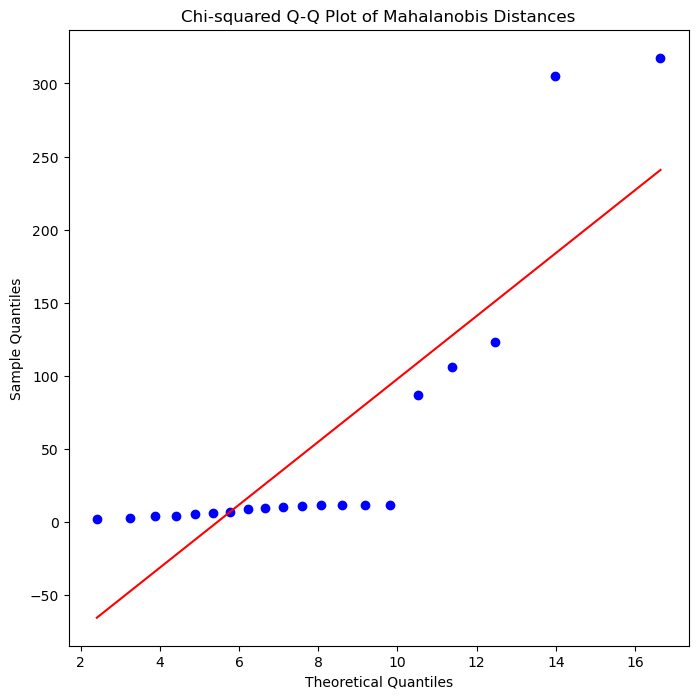

In [20]:
from scipy.stats import chi2 , probplot
from sklearn.preprocessing import StandardScaler
from sklearn.covariance import MinCovDet
import numpy as np
import matplotlib.pyplot as plt
import pingouin as pg

dv_columns = [
    "rouge1", "rouge2", "rougeL", "rougeLsum",
    "bert_score_P", "bert_score_R", "bert_score_F1",
    "sts_score"
]
# Select only the dependent variables (DVs)
X = scores_df[dv_columns].dropna()

# Standardize DVs
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Compute robust Mahalanobis distances
robust_cov = MinCovDet().fit(X_scaled)
mahalanobis_distances = robust_cov.mahalanobis(X_scaled)

# Convert to p-values assuming chi-square distribution
p_values = 1 - chi2.cdf(mahalanobis_distances, df=X.shape[1])

# Estimate what % of observations are likely normal
normality_pass_rate = np.mean(p_values > 0.05)

print(f"Normality pass rate: {normality_pass_rate:.2%}")

# Chi-squared Q-Q plot
plt.figure(figsize=(8, 8))
probplot(mahalanobis_distances, dist="chi2", sparams=(X_scaled.shape[1],), plot=plt)
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Sample Quantiles")
plt.title("Chi-squared Q-Q Plot of Mahalanobis Distances")
plt.show()


In [19]:
# Calculate the threshold for outliers
threshold = chi2.ppf(0.99, df=len(dv_columns))
outliers = mahalanobis_distances > threshold
# Print the number of outliers
print(f"Outlier count: {np.sum(outliers)}")
# identifying the outliers
outlier_indices = np.where(outliers)[0]
outlier_rows = scores_df.iloc[outlier_indices]
print("Outlier rows:")
print(outlier_rows)


Outlier count: 5
Outlier rows:
    chunk_size  questions_num  max_tokens  total_chunks elapsed_time_x  \
0          128              2         128          2000     1:59:42 AM   
1          128              2         256          2000     3:02:02 AM   
10         512              2         128          1722     2:02:23 AM   
15        1024              2         128           910     1:06:14 AM   
17        1024              2         512           910     2:48:49 AM   

      rouge1    rouge2    rougeL  rougeLsum  bert_score_P  bert_score_R  \
0   0.240665  0.171811  0.209919   0.229688      0.714532      0.440610   
1   0.348574  0.237601  0.288869   0.330728      0.710436      0.511877   
10  0.066375  0.045094  0.058550   0.064603      0.670580      0.335312   
15  0.031999  0.021180  0.028436   0.031318      0.593533      0.313629   
17  0.081810  0.059997  0.070784   0.080223      0.637666      0.376273   

    bert_score_F1  sts_score substring_date          elapsed_time_y  
0  

In [29]:
## homogeneity of covariance matrices 
# Box's M test
scores_df["group"] = scores_df["chunk_size"].astype(str)

# Then re-clean and re-test
df_clean = scores_df.dropna(subset=dv_columns + ["group"])
box_m = pg.box_m(data=df_clean, dvs=dv_columns, group='group')
print("Box’s M Test:\n", box_m)

Box’s M Test:
      Chi2     df  pval  equal_cov
box   inf  108.0   0.0      False


/opt/anaconda3/lib/python3.12/site-packages/pingouin/multivariate.py:386: RuntimeWarning: divide by zero encountered in log
  u = -2 * (1 - c) * np.log(M)


In [ ]:
threshold = chi2.ppf(0.999, df=X_scaled.shape[1])  # 99.9% cutoff
outlier_flags = mahalanobis_distances > threshold
num_outliers = np.sum(outlier_flags)

# summary of outlier results
outlier_summary = pd.DataFrame([{
    "Total Observations": len(mahalanobis_distances),
    "Outliers Detected (p < 0.001)": num_outliers,
    "Percentage Outliers": 100 * num_outliers / len(mahalanobis_distances)
}])
print(outlier_summary)

   Total Observations  Outliers Detected (p < 0.001)  Percentage Outliers
0                  20                              5                 25.0


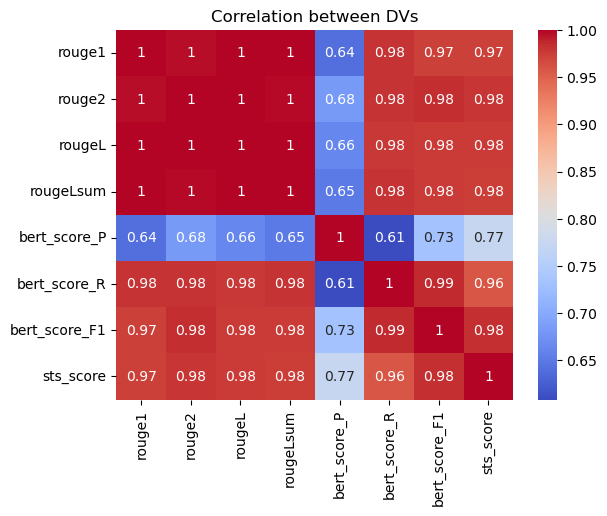

In [30]:
import seaborn as sns

# Check correlation between DVs
sns.heatmap(scores_df[dv_columns].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation between DVs")
plt.show()


In [31]:
# Check for multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
# Add a constant to the model
X_with_const = add_constant(X)
# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["feature"] = X_with_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_with_const.values, i) for i in range(X_with_const.shape[1])]
print(vif_data)

         feature           VIF
0          const   8996.863254
1         rouge1  88353.609271
2         rouge2   4995.350022
3         rougeL  12965.565541
4      rougeLsum  62530.524231
5   bert_score_P    193.709623
6   bert_score_R   4317.033541
7  bert_score_F1   4684.069453
8      sts_score    193.722995
